In [1]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
print(device)

cuda:0


In [2]:


class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(D_in, H), nn.ELU(),
            nn.Linear(H, H), nn.ELU(),
            nn.Linear(H, H//2), nn.ELU(),
            nn.Linear(H//2, H//4), nn.ELU(),
            nn.Linear(H//4, H//8), nn.ELU(),
            nn.Linear(H//8, D_out), nn.Sigmoid())
        
    def forward(self):
        y_pred = torch.zeros(60, 80).to(device)
        for i in range(60):
            for j in range(80):
                x = torch.tensor([(i,j)]).float().requires_grad_()
                x.to(device)
                y_pred[i][j] = self.net(x)
        
        return y_pred.requires_grad_()


In [3]:
from PIL import Image, ImageOps
import numpy as np

def get_grayscale_image_arr(path):
    im = ImageOps.grayscale(Image.open(path))
    image_array = np.array(im).astype(int)
    
    for x in range(im.size[1]):
        for y in range(im.size[0]):
            if image_array[x][y] != 255:
                image_array[x][y] = 0

    image_array = image_array.astype(bool).astype(int)
    return image_array


In [4]:
img_arr = get_grayscale_image_arr('./1st_test.bmp')


In [5]:

# D_in рамерность входа; H скрытая размерность; D_out выход.
D_in, H, D_out, lr = 2, 64, 1, 1

model = Net(D_in, H, D_out)
model

Net(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=8, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [6]:
def loss_fn(y):
    first_integral = y[np.where(img_arr > 0)].sum() / 4583. # хочу НЕ границу единицами    4583 = количество НЕграничных пикселей
    #second_integral = y.abs().sum()
    bound_intgegral = 1 - y[np.where(img_arr == 0)].sum() / 217 # хочу на границе нули
    return bound_intgegral ** 2  + first_integral.abs()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)


In [7]:

for t in range(50):
    optimizer.zero_grad() # обнулил градиенты
    y_pred = model()# заполнил тензор числами
    
    loss = loss_fn(y_pred) # посчитал лосс
    print(f'Epoch {t}, loss: {loss.item()}')

    
    loss.backward() #обновил градиенты
    optimizer.step() #делаю шаг


Epoch 0, loss: 0.7448198795318604
Epoch 1, loss: 0.7446818351745605
Epoch 2, loss: 0.8015813231468201
Epoch 3, loss: 0.8074517250061035
Epoch 4, loss: 0.7499847412109375
Epoch 5, loss: 0.7439968585968018
Epoch 6, loss: 0.7388315796852112
Epoch 7, loss: 0.7341197729110718
Epoch 8, loss: 0.739359438419342
Epoch 9, loss: 0.7618422508239746
Epoch 10, loss: 0.7550369501113892
Epoch 11, loss: 0.7402908802032471
Epoch 12, loss: 0.7334585189819336


KeyboardInterrupt: 

In [8]:
y_pred_new = y_pred  * 225.
y_pred_new

tensor([[110.3178, 107.3871, 104.9230,  ...,  60.9178,  60.6530,  60.3907],
        [112.4521, 110.0790, 107.5070,  ...,  61.3844,  61.1151,  60.8484],
        [114.2768, 112.7533, 110.5554,  ...,  61.8713,  61.5969,  61.3253],
        ...,
        [103.7626, 104.3507, 104.9843,  ..., 119.6532, 119.3774, 119.0487],
        [103.5974, 104.1729, 104.7921,  ..., 119.8976, 119.6869, 119.4369],
        [103.4367, 104.0001, 104.6055,  ..., 120.0602, 119.9001, 119.7095]],
       device='cuda:0', grad_fn=<MulBackward0>)

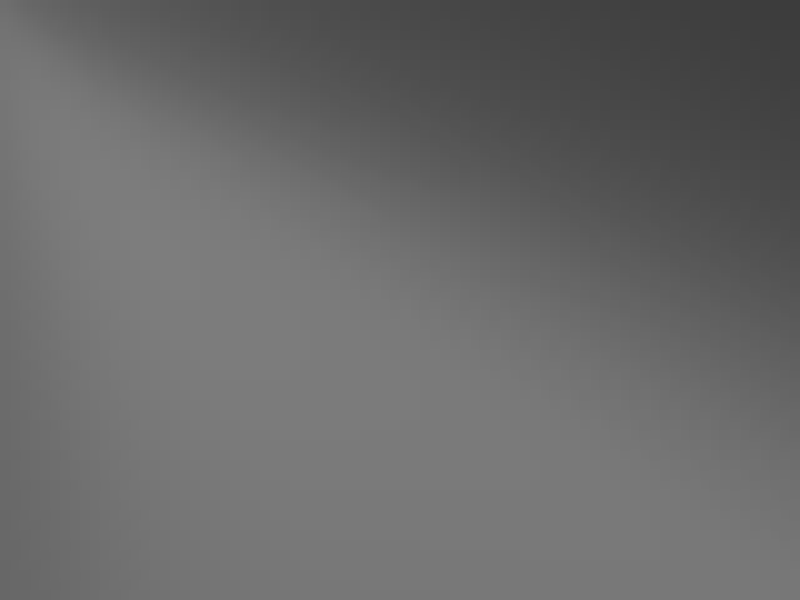

In [9]:
from PIL import Image
Image.fromarray(y_pred_new.cpu().detach().numpy().astype('uint8')).resize((800, 600))